# **<center>Practical Implementation </center>**


## <center> Programming Session 4-3 - Fine-Tuning a Large Language Model for Sentiment Analysis </center>

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://hm-ai.github.io/ml-enpc/">
    <img src="https://drive.google.com/uc?export=view&id=12t-JTO4co2ZDxqdmNOOZG104izf5bSye" height="50"/>
    Course page</a>
</td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1wDTVOGM6HXSF7TVDaKqaIq5fyI-PYcMK?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />Run in Google Colab</a>
  </td>
</table>


This Jupyter Notebook provides a comprehensive guide to fine-tuning a pre-trained language model for sentiment analysis. We'll be using a custom dataset named 'data', which consists of sentences and their corresponding sentiment labels (positive, neutral, or negative). The notebook is structured as follows:

---
## Sections Overview

1. **Environment Setup**: We'll start by setting up the necessary environment, including installing relevant libraries such as `transformers`, `datasets`, and `torchinfo`.

2. **Data Loading and Exploration**: In this section, we load the 'data' dataset, which contains 'sentence' and 'label' columns, and perform initial data exploration to understand its structure and contents.

3. **Data Preprocessing**: Here, we'll preprocess the data by converting sentiment labels into numerical form and splitting the dataset into training and testing sets.

4. **Model Preparation**: We'll prepare the DistilBERT model, a lighter version of BERT, for the task. This includes loading the pre-trained model, configuring it for sentiment analysis, and tokenizing the dataset.

5. **Model Summary**: A brief overview of the model's architecture will be provided to understand its internal workings.

6. **Training Setup**: In this section, we'll set up the training parameters, define the evaluation metrics, and prepare the model for training.

7. **Model Training**: We'll train the model on the preprocessed dataset, adjusting it to better predict the sentiment of new sentences.

8. **Model Evaluation and Inference**: After training, we'll evaluate the model's performance and demonstrate how to use it to predict sentiments of new sentences.

9. **Conclusion**: The notebook will conclude with a summary of what was achieved, insights gained, and potential avenues for future work.

---



# 1. Setting Up the Environment

In [ ]:
!pip install transformers datasets torchinfo
!pip install accelerate -U

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns

# Data Preprocessing

---
<font color=green>Q1:</font>
<br><font color='green'>
Load a dataset from the provided URL into a DataFrame using pandas. What does the DataFrame look like after loading?
</font>

---

In [ ]:
url='https://drive.google.com/uc?id=1Mm_guciU25lS3T919v197tFeMmrbNPOy'
data = pd.read_csv(url)
data = data.sample(frac=0.2).reset_index(drop=True)

---
<font color=green>Q2:</font>
<br><font color='green'>
Create a histogram of the `airline_sentiment` column in the loaded DataFrame. What insights can you draw from this histogram about the sentiment distribution?
</font>

---

<Axes: >

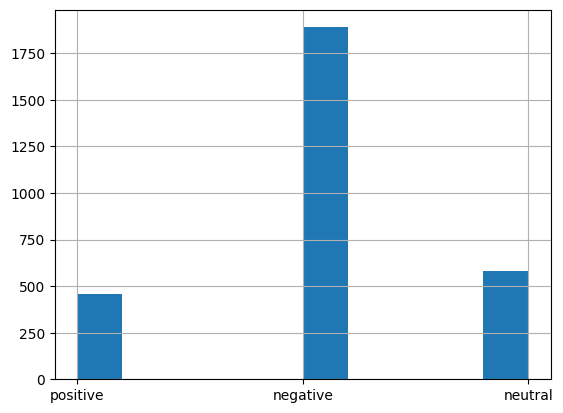

In [ ]:
data["airline_sentiment"].hist()

---
<font color=green>Q3:</font>
<br><font color='green'>
Map the sentiment labels in the `airline_sentiment` column to numerical values: 'positive' to 1, 'negative' to 0, and 'neutral' to 2. Add these numerical values as a new column named `target` in the DataFrame. Show the first few rows of the updated DataFrame.
</font>

---

In [ ]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
data['target'] = data['airline_sentiment'].map(target_map)

---
<font color=green>Q4:</font>
<br><font color='green'>
Create a new DataFrame selecting only the `text` and `target` columns from the current DataFrame. Rename these columns to `sentence` and `label`, respectively.
</font>

---

In [ ]:
df = data[['text', 'target']]
df.columns = ['sentence', 'label']

---
<font color=green>Q5:</font>
<br><font color='green'>
Save the newly created DataFrame to a CSV file named `data.csv` without the index.
</font>

---

In [ ]:
df.to_csv('data.csv', index=None)

In [ ]:
!ls

data.csv  sample_data  training_dir


---
<font color=green>Q6:</font>
<br><font color='green'>
Using the `datasets` library, load a dataset from a CSV file named 'data.csv' using the following code:
```python
raw_dataset = load_dataset('csv', data_files=<filename>)
```
</font>

---

Once loaded, the dataset will be in a 'DatasetDict' format, typically containing a single key 'train' for the entire dataset.

'DatasetDict' is a type used in the datasets library, which is part of the Hugging Face ecosystem widely used in machine learning and natural language processing. It's a Python dictionary-like container specifically designed for handling datasets in machine learning workflows.

DatasetDict behaves similarly to a Python dictionary. Each key-value pair corresponds to a specific subset of the dataset, such as training, validation, or test splits.




In [ ]:
raw_dataset = load_dataset('csv', data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

---
<font color=green>Q7:</font>
<br><font color='green'>
After loading the dataset, split it into training and test sets with a 70-30 split using the train_test_split() method. This method should be applied to the dataset under the 'train' key. Specify a test size of 30% and set the seed to 42 for reproducibility.
</font>

---


In [ ]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [ ]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2049
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 879
    })
})

# Model Preparation

---
<font color=green>Q8:</font>
<br><font color='green'>
Using the Hugging Face transformers library, import the classes AutoTokenizer, AutoModelForSequenceClassification, and AutoConfig. Write the code for this import statement.
</font>

---

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

---
<font color=green>Q9:</font>
<br><font color='green'>
Set a variable named checkpoint to the string 'distilbert-base-cased', which specifies the model checkpoint for DistilBERT, a lighter version of BERT.
</font>

---

In [ ]:
checkpoint = 'distilbert-base-cased'

---
<font color=green>Q10:</font>
<br><font color='green'>
Initialize a tokenizer for the DistilBERT model using the AutoTokenizer.from_pretrained method with the checkpoint variable. Store this tokenizer in a variable named tokenizer.
</font>

---

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

---
<font color=green>Q11:</font>
<br><font color='green'>
Define a function named tokenize_fn that takes a batch of data as input and returns the tokenized output. Inside the function, use the tokenizer's method with batch['sentence'] as input and enable truncation.
</font>

---

In [ ]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)

---
<font color=green>Q12:</font>
<br><font color='green'>
Apply the tokenize_fn function to your dataset split using the .map method. Make sure to set the batched parameter to True for efficient processing. Assign the result to a variable named tokenized_datasets.
</font>

---

In [ ]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/2049 [00:00<?, ? examples/s]

Map:   0%|          | 0/879 [00:00<?, ? examples/s]

---
<font color=green>Q13:</font>
<br><font color='green'>
Load the configuration for the DistilBERT model using AutoConfig.from_pretrained with the checkpoint variable. Store this configuration in a variable named config.
</font>

---

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)

---
<font color=green>Q14:</font>
<br><font color='green'>
Create a mapping in the config object for the sentiment labels (positive, negative, neutral) to numerical values and vice versa using a dictionary named target_map. Update config.id2label and config.label2id with this mapping.
</font>

---

In [ ]:
config.id2label = {v: k for k, v in target_map.items()}
config.label2id = target_map

---
<font color=green>Q15:</font>
<br><font color='green'>
Initialize a DistilBERT model for sequence classification using AutoModelForSequenceClassification.from_pretrained. Pass in the checkpoint and the customized config as arguments. Assign this model to a variable named model.
</font>

---

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Model Summary

---
<font color=green>Q16:</font>
<br><font color='green'>
Import the summary function from the torchinfo library and use it to display a detailed summary of the architecture of your pre-trained model stored in the variable model.
</font>

---

In [ ]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

# Training Setup

---
<font color=green>Q17:</font>
<br><font color='green'>
Import the Trainer and TrainingArguments classes from the transformers library.
</font>

---

In [ ]:
from transformers import Trainer, TrainingArguments

---
<font color=green>Q18:</font>
<br><font color='green'>
Create a TrainingArguments object with the following specifications: output_dir, evaluation_strategy and save_strategy, num_train_epochs, per_device_train_batch_size, and per_device_eval_batch_size. Assign this object to a variable named training_args.
</font>

---

In [ ]:
# Setting up training arguments
training_args = TrainingArguments(
    output_dir='training_dir',  # Directory where the model predictions and checkpoints will be written.
    evaluation_strategy='epoch',  # Evaluation is done at the end of each epoch.
    save_strategy='epoch',  # Model checkpoints are saved at the end of each epoch.
    num_train_epochs=3,  # Number of training epochs. This is the number of times the model will see the entire dataset.
    per_device_train_batch_size=16,  # Batch size per device during training.
    per_device_eval_batch_size=64,  # Batch size for evaluation.
)


---
<font color=green>Q19:</font>
<br><font color='green'>
Define a function named compute_metrics that takes an argument logits_and_labels, which is a tuple of model logits and true labels. Inside the function, use np.argmax to convert logits to class predictions, calculate the accuracy (acc) as the mean of correct predictions, and use f1_score from sklearn.metrics to calculate the F1 score with average='macro'. The function should return a dictionary with keys 'accuracy' and 'f1' corresponding to these metrics.
</font>

---

In [ ]:
# Defining a function to compute metrics
def compute_metrics(logits_and_labels):
    """
    Function to compute the accuracy and F1 score of the model predictions.
    Args:
        logits_and_labels: A tuple containing model logits and true labels.
    Returns:
        A dictionary with keys 'accuracy' and 'f1' corresponding to the computed metrics.
    """
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)  # Converting logits to class predictions.
    acc = np.mean(predictions == labels)  # Calculating accuracy.
    f1 = f1_score(labels, predictions, average='macro')  # Calculating F1 score.
    return {'accuracy': acc, 'f1': f1}  # Returning the computed metrics.

---
<font color=green>Q20:</font>
<br><font color='green'>
Initialize a Trainer object with the pre-defined model (model), training_args, the training dataset (tokenized_datasets["train"]), the evaluation dataset (tokenized_datasets["test"]), the tokenizer (tokenizer), and the compute_metrics function. Assign this Trainer object to a variable named trainer.
</font>

---

In [ ]:
# Initializing the Trainer
trainer = Trainer(
    model=model,  # The model to be trained.
    args=training_args,  # The training arguments set above.
    train_dataset=tokenized_datasets["train"],  # The training dataset.
    eval_dataset=tokenized_datasets["test"],  # The evaluation dataset.
    tokenizer=tokenizer,  # The tokenizer used for the model.
    compute_metrics=compute_metrics,  # The function used to compute metrics for evaluation.
)

# Model Training

---
<font color=green>Q21:</font>
<br><font color='green'>
Initiate the training process using the Trainer instance you have set up. This instance should already be configured with the model, training arguments, dataset, and necessary functions for computing metrics.
</font>

---

In [ ]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.605927,0.762230,0.675577
2,No log,0.612001,0.790671,0.708703
3,No log,0.709218,0.789534,0.726380


TrainOutput(global_step=387, training_loss=0.3689418664582324, metrics={'train_runtime': 2304.1175, 'train_samples_per_second': 2.668, 'train_steps_per_second': 0.168, 'total_flos': 78587685727488.0, 'train_loss': 0.3689418664582324, 'epoch': 3.0})

# Model Inference & Evaluation

In [ ]:
!ls training_dir

checkpoint-128	checkpoint-192	checkpoint-32	checkpoint-64
checkpoint-129	checkpoint-258	checkpoint-387	runs


---
<font color=green>Q22:</font>
<br><font color='green'>
Import the pipeline function from the transformers library.
</font>

---



In [ ]:
from transformers import pipeline

---
<font color=green>Q23:</font>
<br><font color='green'>
Create a text classification pipeline using the pipeline function. Set the task to 'text-classification'. Load a model from a saved checkpoint. Assign this pipeline to a variable named savedmodel.
</font>

---

In [ ]:
savedmodel = pipeline('text-classification', model='training_dir/checkpoint-128')

---
<font color=green>Q24:</font>
<br><font color='green'>
Select the first sentence from the test dataset for classification. Use the savedmodel pipeline to classify the sentiment of the selected sentence.
</font>

---

In [ ]:
s = split['test']['sentence'][42]
print(s)
savedmodel(s)

@united how come a $27 shuttle bus from LGA to EWR has electrical power outlets but our new Airbus interiors do not? #whyjeff?


[{'label': 'negative', 'score': 0.7195581197738647}]

---
<font color=green>Q25:</font>
<br><font color='green'>
Using the savedmodel pipeline for text classification, predict the sentiment labels for all sentences in the test dataset. Then, calculate the accuracy and F1 score of these predictions compared to the actual labels. Finally, create and display a normalized confusion matrix using seaborn's heatmap to visualize the model's performance across different sentiment classes.
</font>

---

In [ ]:
test_pred = savedmodel(split['test']['sentence'])

In [ ]:
def get_label(d):
  return int(target_map[d['label']])

test_pred = [get_label(d) for d in test_pred]

In [ ]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.7977272727272727


In [ ]:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))


f1: 0.7210831051647536


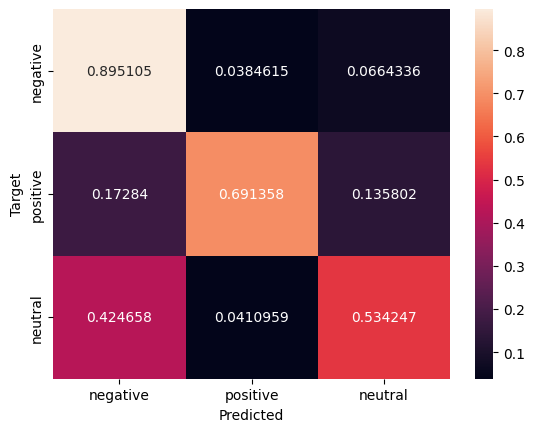

In [ ]:
def plot_cm(cm):
  classes = ['negative', 'positive', 'neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)

# Conclusion

In this notebook, we navigated through several critical steps in fine-tuning a large language model for sentiment analysis:

* Environment Setup: Initialized our workspace with essential libraries like transformers and datasets.

* Data Preparation: Loaded, explored, and preprocessed our dataset, converting sentiment labels to numerical values and splitting the dataset.

* Model Preparation and Configuration: Employed DistilBERT, configured it, and tokenized the dataset for compatibility.

* Model Training: Defined training parameters, trained our model, and implemented a function to compute metrics like accuracy and F1 score.

* Model Evaluation: Assessed the trained model's performance using the test data to gauge its real-world applicability.

* Model Inference and Evaluation: Demonstrated the use of the trained model for sentiment classification on new sentences using the Hugging Face pipeline.

## Contact

If you have any question regarding this notebook, please do not hesitate to contact: hachem.madmoun@gmail.com